# Importing modules

In [1]:
import os
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)

# LGLD-Net architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class InvolutionLayer(nn.Module):

    ''' Dynamically creates spatially adaptive, channel-agnostic kernels based on the input. '''

    def __init__(self, channels, kernel_size=3, reduction=4):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        mid_channels = channels // reduction
        self.reduce = nn.Conv2d(channels, mid_channels, 1)
        self.shared_mlp = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(mid_channels, kernel_size * kernel_size, 1)
        )
        self.unfold = nn.Unfold(kernel_size, padding=self.padding)

    def forward(self, x):
        B, C, H, W = x.size()
        reduced = self.reduce(x)
        kernels = self.shared_mlp(reduced)
        kernels = kernels.view(B, 1, self.kernel_size * self.kernel_size, H * W)
        patches = self.unfold(x).view(B, C, self.kernel_size * self.kernel_size, H * W)
        out = (kernels * patches).sum(dim=2)
        return out.view(B, C, H, W)


class IPS(nn.Module):

    ''' Extraction of low-level local features using Involution layer rather than a standard convolution. '''

    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.invo = InvolutionLayer(out_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.invo(self.conv(x))))


class FourierFeatureMixer(nn.Module):

    ''' Addition of sinusoidal positional encoding terms along the spatial axes. 
        This helps in preserving the spatial structure and relative positional information of the input features.
    '''

    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        assert out_channels % 2 == 0
        self.proj = nn.Conv2d(in_channels + 4, out_channels, 1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU(inplace=True)
        self.register_parameter("fourier_weight_real", nn.Parameter(torch.randn(out_channels // 2)))
        self.register_parameter("fourier_weight_imag", nn.Parameter(torch.randn(out_channels // 2)))

    def forward(self, x):
        B, C, H, W = x.size()
        i = torch.arange(H, device=x.device).view(1, 1, H, 1).expand(B, 1, H, W)
        j = torch.arange(W, device=x.device).view(1, 1, 1, W).expand(B, 1, H, W)
        pe = torch.cat([
            torch.sin(2 * torch.pi * i / max(H, 1)), torch.cos(2 * torch.pi * i / max(H, 1)),
            torch.sin(2 * torch.pi * j / max(W, 1)), torch.cos(2 * torch.pi * j / max(W, 1))
        ], dim=1)
        x = torch.cat([x, pe], dim=1)
        x = self.proj(x)
        real, imag = torch.chunk(x, 2, dim=1)
        real = real * self.fourier_weight_real.view(1, -1, 1, 1)
        imag = imag * self.fourier_weight_imag.view(1, -1, 1, 1)
        return self.act(self.bn(torch.cat([real, imag], dim=1)))


class LFA(nn.Module):

    ''' Captures fine-grained structures at different scales, thereby enhancing local representation.
        Parallel depthwise convolutions with different receptive fields extract spatial features.
        The learned representations are fused and passed through the non-linear activation.
    '''

    def __init__(self, channels):
        super().__init__()
        self.dw3 = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, groups=channels),
            nn.Conv2d(channels, channels, 1),
            nn.SiLU(inplace=True)
        )
        self.dw5 = nn.Sequential(
            nn.Conv2d(channels, channels, 5, padding=2, groups=channels),
            nn.Conv2d(channels, channels, 1),
            nn.SiLU(inplace=True)
        )
        self.project = nn.Conv2d(channels * 2, channels, 1, bias=False)
        self.act = nn.SiLU(inplace=True)

    def forward(self, x):
        out = self.project(torch.cat([self.dw3(x), self.dw5(x)], dim=1))
        return self.act(x + out)


class GCE(nn.Module):

    ''' The main functionality is to capture global context information by broadening the receptive field
        It is achieved by using dilated convolutions to capture long-range dependencies. 
        The aggregated features are refined using a squeeze-and-excitation attention block, emphasizing globally
        important features.
    '''


    def __init__(self, channels, reduction=4):
        super().__init__()
        self.dil2 = nn.Conv2d(channels, channels, 3, padding=2, dilation=2)
        self.dil4 = nn.Conv2d(channels, channels, 3, padding=4, dilation=4)
        self.dil8 = nn.Conv2d(channels, channels, 3, padding=8, dilation=8)
        self.compress = nn.Conv2d(channels * 3, channels, 1)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        p = torch.cat([self.dil2(x), self.dil4(x), self.dil8(x)], dim=1)
        p = self.compress(p)
        p = F.silu(p)
        return p * self.se(p)


class LGFM(nn.Module):

    ''' Aggregation of the complementary features from the local and global streams 
        A compact MLP learns the relative importance of each stream.
        This ensures that the network can prioritize spatial detail or global context as needed.
    '''

    def __init__(self, channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channels * 2, 2),  
        )

    def forward(self, x_l, x_g):
        stats = torch.cat([x_l, x_g], dim=1)
        w = F.softmax(self.fc(stats), dim=1)  
        w_l = w[:, 0].view(-1, 1, 1, 1)
        w_g = w[:, 1].view(-1, 1, 1, 1)
        return w_l * x_l + w_g * x_g


class DualStreamLGLDNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, num_classes=4):
        super().__init__()
        self.local_stem = IPS(in_channels, base_channels)
        self.global_stem = FourierFeatureMixer(in_channels, base_channels)
        self.lfa = LFA(base_channels)
        self.gce = GCE(base_channels)
        self.lgfm = LGFM(base_channels)

        # Head for classification
        self.head = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, 1),
            nn.BatchNorm2d(base_channels),
            nn.SiLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(base_channels, num_classes)
        )

    def forward(self, x):
        local_feat = self.lfa(self.local_stem(x))
        global_feat = self.gce(self.global_stem(x))
        fused_feat = self.lgfm(local_feat, global_feat)
        
        return self.head(fused_feat)

# loading dataset

In [ ]:
# Paths
input_dir = "/kaggle/input/leukemia/Original"
split_dir = "/kaggle/working/split_data"
train_path = os.path.join(split_dir, "train")
val_path = os.path.join(split_dir, "val")
test_path = os.path.join(split_dir, "test")


transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = datasets.ImageFolder(input_dir, transform=transform)
targets = [label for _, label in dataset.imgs]
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Split 80-10-10
train_idx, temp_idx, _, temp_targets = train_test_split(
    range(len(targets)), targets, test_size=0.2, stratify=targets, random_state=42)

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_targets, random_state=42)


def copy_images(indices, dest_dir):
    for idx in indices:
        src, label = dataset.imgs[idx]
        cls = idx_to_class[label]
        tgt = os.path.join(dest_dir, cls)
        os.makedirs(tgt, exist_ok=True)
        shutil.copy(src, os.path.join(tgt, os.path.basename(src)))

if os.path.exists(split_dir):
    shutil.rmtree(split_dir)

copy_images(train_idx, train_path)
copy_images(val_idx, val_path)
copy_images(test_idx, test_path)


train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Training Loop

In [ ]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualStreamLGLDNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 50
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step()

    for param_group in optimizer.param_groups:
        print(f"Learning Rate: {param_group['lr']:.6f}")

Epoch 1/50 | Train Loss: 0.6604 | Train Acc: 78.69% | Val Loss: 8.6911 | Val Acc: 29.75%
Learning Rate: 0.010000
Epoch 2/50 | Train Loss: 0.3709 | Train Acc: 87.44% | Val Loss: 6.6559 | Val Acc: 39.57%
Learning Rate: 0.010000
Epoch 3/50 | Train Loss: 0.2532 | Train Acc: 91.97% | Val Loss: 1.9789 | Val Acc: 64.11%
Learning Rate: 0.010000
Epoch 4/50 | Train Loss: 0.1747 | Train Acc: 94.20% | Val Loss: 13.2748 | Val Acc: 29.75%
Learning Rate: 0.010000
Epoch 5/50 | Train Loss: 0.1689 | Train Acc: 94.85% | Val Loss: 6.1491 | Val Acc: 36.50%
Learning Rate: 0.005000
Epoch 6/50 | Train Loss: 0.1260 | Train Acc: 95.93% | Val Loss: 0.2371 | Val Acc: 92.33%
Learning Rate: 0.005000
Epoch 7/50 | Train Loss: 0.0945 | Train Acc: 97.00% | Val Loss: 0.9696 | Val Acc: 79.75%
Learning Rate: 0.005000
Epoch 8/50 | Train Loss: 0.0844 | Train Acc: 97.58% | Val Loss: 1.5429 | Val Acc: 61.35%
Learning Rate: 0.005000
Epoch 9/50 | Train Loss: 0.1036 | Train Acc: 96.89% | Val Loss: 0.2214 | Val Acc: 94.79%
Learni

# Accuracy and Loss plots

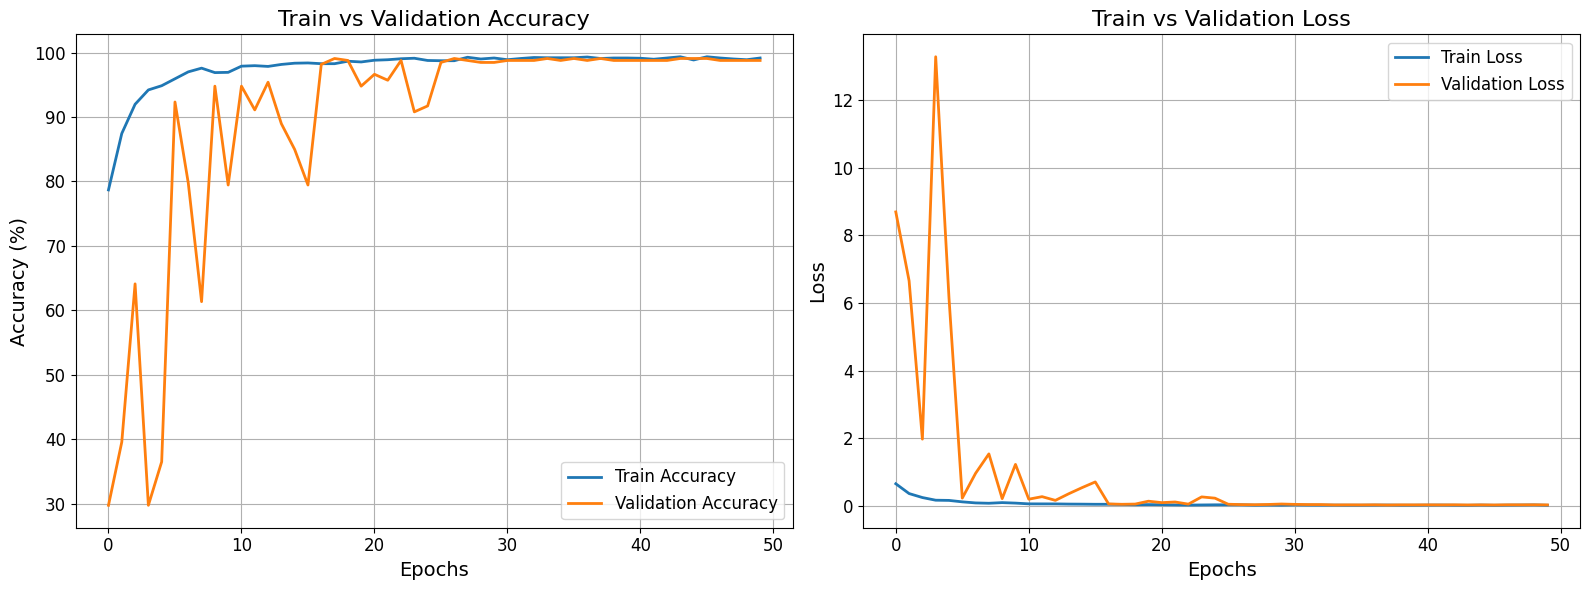

In [ ]:
import matplotlib.pyplot as plt

torch.save(model.state_dict(), '/kaggle/working/lgldnet_all_silu.pth')

plt.figure(figsize=(16, 6)) 

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Train Accuracy", linewidth=2)
plt.plot(val_accuracies, label="Validation Accuracy", linewidth=2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("Train vs Validation Accuracy", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Train vs Validation Loss", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Class-wise Performance and Classification Report

In [8]:
from sklearn.metrics import classification_report
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


try:
    class_names = test_dataset.classes  
except:
    class_names = [f"Class {i}" for i in np.unique(all_labels)]


test_acc = 100 * (all_preds == all_labels).sum() / len(all_labels)
print(f"\nTest Accuracy: {test_acc:.2f}%")


print("\nPer-Class Accuracy:")
for idx, class_name in enumerate(class_names):
    mask = (all_labels == idx)
    correct = (all_preds[mask] == idx).sum()
    total = mask.sum()
    acc = 100 * correct / total if total > 0 else 0.0
    print(f"• {class_name}: {acc:.2f}%")


print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Test Accuracy: 99.69%

Per-Class Accuracy:
• Benign: 100.00%
• Early: 98.99%
• Pre: 100.00%
• Pro: 100.00%

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9804    1.0000    0.9901        50
       Early     1.0000    0.9899    0.9949        99
         Pre     1.0000    1.0000    1.0000        96
         Pro     1.0000    1.0000    1.0000        81

    accuracy                         0.9969       326
   macro avg     0.9951    0.9975    0.9963       326
weighted avg     0.9970    0.9969    0.9969       326



# Learned Features Extraction

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

all_features = []
all_labels = []
all_preds = []
all_probs = []


def extract_features(x):
    with torch.no_grad():
        local_feat = model.lfa(model.local_stem(x))
        global_feat = model.gce(model.global_stem(x))
        fused_feat = model.lgfm(local_feat, global_feat)
        pooled = F.adaptive_avg_pool2d(fused_feat, 1).flatten(1)
        return pooled, model.head(fused_feat)


for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    features, logits = extract_features(inputs)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)

    all_features.append(features.cpu().numpy())
    all_labels.append(labels.cpu().numpy())
    all_preds.append(preds.cpu().numpy())
    all_probs.append(probs.cpu().numpy())


features_np = np.vstack(all_features)
labels_np = np.concatenate(all_labels)
preds_np = np.concatenate(all_preds)
probs_np = np.vstack(all_probs)

100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


# t-SNE Plot

Class Mapping (index -> class name):
0 -> Benign
1 -> Early
2 -> Pre
3 -> Pro


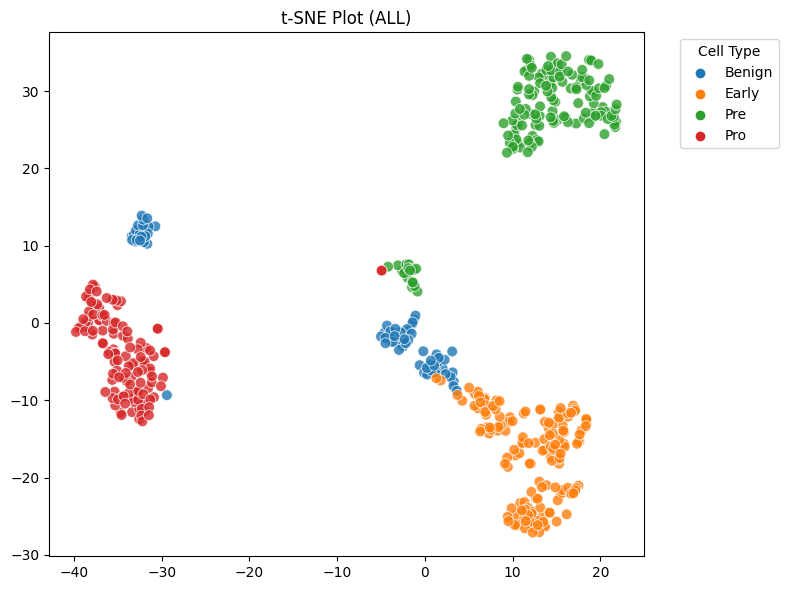

In [9]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(features_np)

class_idx_to_name = test_dataset.classes 
print("Class Mapping (index -> class name):")
for idx, name in enumerate(class_idx_to_name):
    print(f"{idx} -> {name}")

label_names = [class_idx_to_name[idx] for idx in labels_np]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=label_names, palette='tab10', s=60, alpha=0.8)
plt.title('t-SNE Plot (ALL)')
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Confusion Matrix

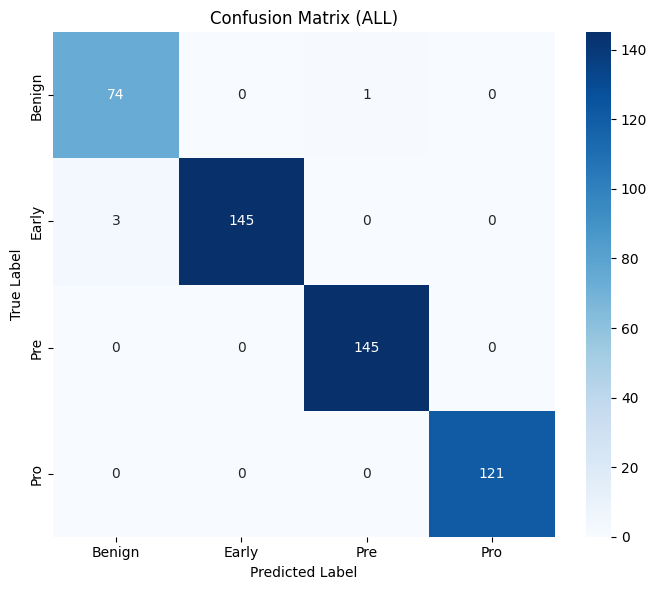

In [10]:
cm = confusion_matrix(labels_np, preds_np)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_idx_to_name, yticklabels=class_idx_to_name)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (ALL)')
plt.tight_layout()
plt.show()

# Precision-Recall Curve

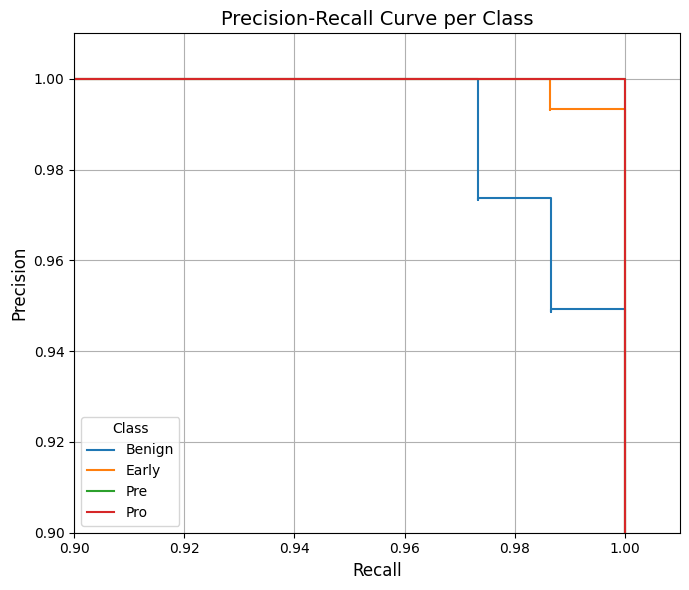

In [5]:
plt.figure(figsize=(7, 6))

for i in range(probs_np.shape[1]):
    y_true = (labels_np == i).astype(int)
    if np.sum(y_true) == 0:
        print(f"Class {i} ({test_dataset.classes[i]}) has no samples in test set.")
        continue
    precision, recall, _ = precision_recall_curve(y_true, probs_np[:, i])
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name=test_dataset.classes[i], ax=plt.gca())

plt.title("Precision-Recall Curve per Class", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.xlim(0.9, 1.01) 
plt.ylim(0.9, 1.01)  
plt.legend(loc="lower left", title="Class")
plt.grid(True)
plt.tight_layout()
plt.show()
